In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Praktikum/Praktikum10/Data/weather_classification_data.csv"

In [ ]:
df = pd.read_csv(path)
print("Loaded dataset shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head())

Loaded dataset shape: (13200, 11)
Columns: ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season', 'Visibility (km)', 'Location', 'Weather Type']
   Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0        73         9.5               82.0  partly cloudy   
1         39.0        96         8.5               71.0  partly cloudy   
2         30.0        64         7.0               16.0          clear   
3         38.0        83         1.5               82.0          clear   
4         27.0        74        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0               1010.82         2  Winter              3.5    inland   
1               1011.43         7  Spring             10.0    inland   
2               1018.72         5  Spring              5.5  mountain   
3               1026.25         7  Spring            

In [ ]:
label_encoders = {}
df_proc = df.copy()

In [ ]:
cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns.tolist()
# Ensure target included
if 'Weather Type' not in cat_cols and df_proc['Weather Type'].dtype != 'int64':
    cat_cols.append('Weather Type')

print("Categorical columns detected:", cat_cols)

for col in cat_cols:
    le = LabelEncoder()
    df_proc[col] = le.fit_transform(df_proc[col].astype(str))
    label_encoders[col] = le


Categorical columns detected: ['Cloud Cover', 'Season', 'Location', 'Weather Type']


In [ ]:
X = df_proc.drop('Weather Type', axis=1)
y = df_proc['Weather Type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)
print("Train / Test sizes:", X_train.shape, X_test.shape)

Train / Test sizes: (10560, 10) (2640, 10)


In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
param_grid = {'n_neighbors': [3,5,7,9,11]}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_k = grid.best_params_['n_neighbors']
print("GridSearch best k:", best_k)
print("Best CV score:", grid.best_score_)

GridSearch best k: 7
Best CV score: 0.9005681818181819


In [ ]:
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=7)

In [ ]:
y_pred = final_knn.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.8955

Classification Report:

              precision    recall  f1-score   support

           0     0.8457    0.8970    0.8706       660
           1     0.8700    0.8924    0.8811       660
           2     0.9390    0.9091    0.9238       660
           3     0.9343    0.8833    0.9081       660

    accuracy                         0.8955      2640
   macro avg     0.8972    0.8955    0.8959      2640
weighted avg     0.8972    0.8955    0.8959      2640

Confusion Matrix:
 [[592  47   5  16]
 [ 32 589  29  10]
 [ 27  18 600  15]
 [ 49  23   5 583]]


In [ ]:
target_le = label_encoders['Weather Type']
class_names = target_le.inverse_transform(np.arange(len(target_le.classes_)))

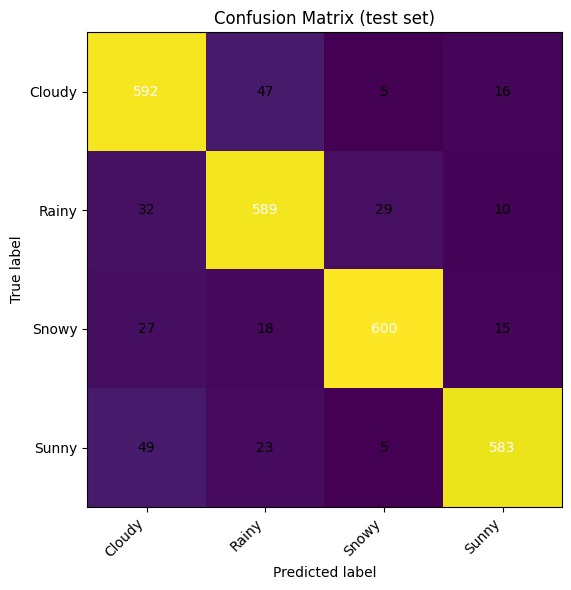

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (test set)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
